In [1]:
import numpy as np
import math as m
import cmath as cm
import pandas as pd
import os
import matplotlib.pyplot as plt
import plotly
import spicy


In [2]:
# DATA
V_cutin = 3
V_rated = 12
Nnom = 22.5
Pnom = 4*10**6
k = Pnom/Nnom**3
N_min = (Nnom/V_rated)*V_cutin

# GENERATOR
p = 52/2
Rg = 14.821*10**-3
Lg = 5.573*10**-3
psi = 15.826

def generator(N, p, Rg, Lg, psi, case):

    fs = N*p/60
    omega = 2*np.pi*fs

    Pmech = k*N**3

    Zg = Rg + 1j*omega*Lg

    Ea = omega*psi
    
    if case=="a":

        # Polynonmial equation
        p = [0]*5
        p[0] = (3*abs(omega*Lg))**2
        p[1] = 0
        p[2] = - (3*abs(Ea))**2
        p[3] = 0
        p[4] = Pmech**2
        roots = np.roots(p)
        #print("roots : ", roots)
        
        Ia=roots[-1]

        Va = Pmech/(3*Ia) - Rg*Ia
        
        angle = np.arccos((Va+Rg*Ia)/Ea)*180/np.pi

    if case=="b":

        Ia = Pmech/(3*Ea)

        Va = Ea - Ia*Zg

        angle = - np.angle(Va,deg=True)

        Ia = cm.rect(Ia,angle*np.pi/180)

    Ea = cm.rect(Ea,angle*np.pi/180)
    Va = cm.rect(abs(Va),0)

    Sa = 3*Va*np.conjugate(Ia)
    Pa = Sa.real
    Qa = Sa.imag
    
    Ploss = Pmech - Pa
    efficiency = Pa/Pmech

    # print('Sa = ', Sa, abs(Sa),np.angle(Sa,deg=True))
    # print('Ia = ', Ia, abs(Ia),np.angle(Ia,deg=True))
    # print('Va = ', Va, abs(Va),np.angle(Va,deg=True))
    # print('Zg = ',Zg, abs(Zg), np.angle(Zg,deg=True))
    # print('Ea = ',Ea, abs(Ea), np.angle(Ea,deg=True))

    return([fs,omega,Pmech,Zg,Ia,Va,Ea,angle,Sa,Pa,Qa,Ploss,efficiency])

case_a = generator(Nnom, p, Rg, Lg, psi, "a")
case_b = generator(Nnom, p, Rg, Lg, psi, "b")



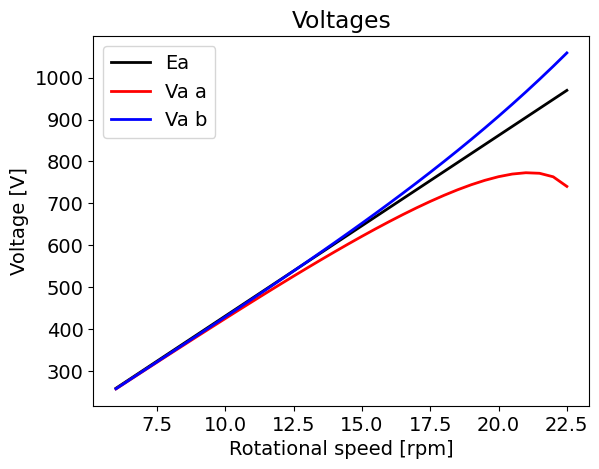

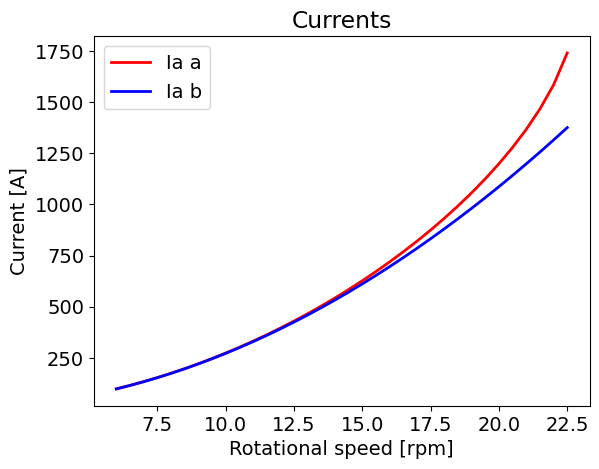

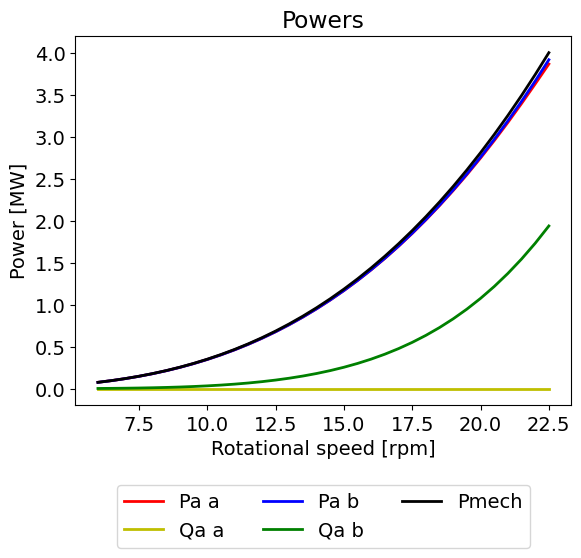

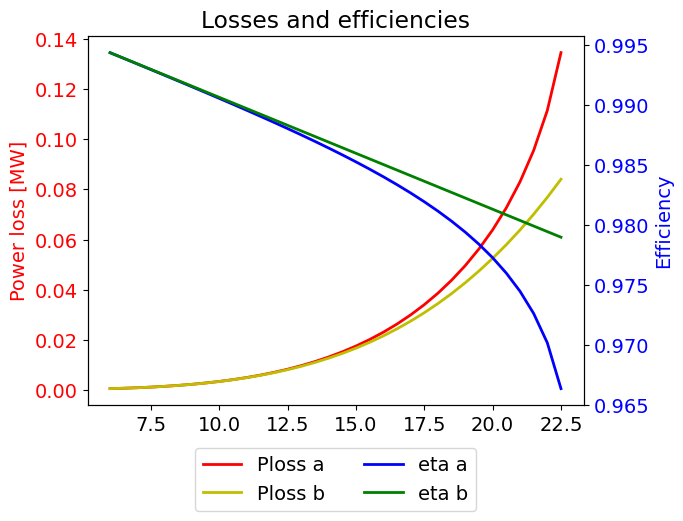

In [3]:
list_N = np.arange(np.ceil(N_min),23,0.5)

data_a = []
data_b = []
for N in list_N :
    data_a.append([N]+generator(N, p, Rg, Lg, psi, "a"))
    data_b.append([N]+generator(N, p, Rg, Lg, psi, "b"))


#Data_a = pd.DataFrame(data_a, columns=[fs,omega,Pmech,Zg,Ia,Va,Ea,angle,Sa,Pa,Qa,Ploss,efficiency])
#Data_b = pd.DataFrame(data_b, columns=[fs,omega,Pmech,Zg,Ia,Va,Ea,angle,Sa,Pa,Qa,Ploss,efficiency])

Data_a = pd.DataFrame(data_a, columns=['N','fs','omega','Pmech','Zg','Ia','Va','Ea','angle','Sa','Pa','Qa','Ploss','efficiency'])
Data_b = pd.DataFrame(data_b, columns=['N','fs','omega','Pmech','Zg','Ia','Va','Ea','angle','Sa','Pa','Qa','Ploss','efficiency'])

plt.rcParams.update({'font.size': 14})

plt.figure(1) 
plt.plot(Data_a['N'], abs(Data_a["Ea"]), zorder=1, color='k', linewidth=2, linestyle='solid', label="Ea")
plt.plot(Data_a['N'], abs(Data_a["Va"]), zorder=1, color='r', linewidth=2, linestyle='solid', label="Va a")
plt.plot(Data_b['N'], abs(Data_b["Va"]), zorder=2, color='b', linewidth=2, linestyle='solid', label="Va b")
plt.legend()
plt.title('Voltages')
plt.xlabel('Rotational speed [rpm]')
plt.ylabel('Voltage [V]')
plt.show()
    
plt.figure(2) 
plt.plot(Data_a['N'], abs(Data_a["Ia"]), zorder=1, color='r', linewidth=2, linestyle='solid', label="Ia a")
plt.plot(Data_b['N'], abs(Data_b["Ia"]), zorder=1, color='b', linewidth=2, linestyle='solid', label="Ia b")
plt.legend()
plt.title('Currents')
plt.xlabel('Rotational speed [rpm]')
plt.ylabel('Current [A]')
plt.show()

fig, ax = plt.subplots()
ax.plot(Data_a['N'], Data_a["Pa"]     /10**6,    linewidth=2, color='r', linestyle='solid', label="Pa a")
ax.plot(Data_a['N'], abs(Data_a["Qa"])/10**6,    linewidth=2, color='y', linestyle='solid', label="Qa a")
ax.plot(Data_b['N'], Data_b["Pa"]     /10**6,    linewidth=2, color='b', linestyle='solid', label="Pa b")
ax.plot(Data_b['N'], abs(Data_b["Qa"])/10**6,    linewidth=2, color='g', linestyle='solid', label="Qa b")
ax.plot(Data_a['N'], Data_a["Pmech"]  /10**6,    linewidth=2, color='k', linestyle='solid', label="Pmech")
legend = ax.legend(loc='center', bbox_to_anchor=(0.5, -0.3), ncol=3)
ax.set_title('Powers')
ax.set_xlabel('Rotational speed [rpm]')
ax.set_ylabel('Power [MW]')



fig, ax1 = plt.subplots()
ax1.plot(Data_a['N'], Data_a["Ploss"]/10**6, linewidth=2, color='r', linestyle='solid', label="Ploss a")
ax1.plot(Data_b['N'], Data_b["Ploss"]/10**6, linewidth=2, color='y', linestyle='solid', label="Ploss b")
ax1.set_ylabel('Power loss [MW]', color='r')
ax1.tick_params(axis='y', labelcolor='r')

ax2 = ax1.twinx()
ax2.plot(Data_a['N'], Data_a["efficiency"], linewidth=2, color='b', linestyle='solid', label="eta a")
ax2.plot(Data_b['N'], Data_b["efficiency"], linewidth=2, color='g', linestyle='solid', label="eta b")
ax2.set_ylabel('Efficiency', color='b')
ax2.tick_params(axis='y', labelcolor='b')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax1.legend(lines, labels, loc='center', bbox_to_anchor=(0.5, -0.2), ncol=2)
ax1.set_title('Losses and efficiencies')

plt.show()

In [4]:
# from Vgrid to Vt1

L = 60              # [Km]
Rc = 0.5*L
Lc = 0.5*10**-3*L
Cc = 0.1*10**-6*L

omega_grid = 2*np.pi*50
Zc1 = Rc + 1j*omega_grid*Lc
Zc2 = -1j*1/(omega_grid*Cc)

N1 = 690
N2 = 33*10**3
a = N1/N2

L1_p = 20*10**-6
L2_p = 20*10**-6
L2_s = L2_p/a**2
R1_p = 10*10**-3
R2_p = 10*10**-3
R2_s = R2_p/a**2
Ls = 25*10**-3
Rs = 124

Zt1 = R1_p + 1j*omega_grid*L1_p
Zs = 1/(1/Rs + 1/(1j*omega_grid*Ls))
Zt2 = R2_s + 1j*omega_grid*L2_s
Z2 = Zt2 + Zc1

def transformer(Pa):

    # Converter
    Pb = Pa
    Qb = 0.2*Pa
    St1 = Pb + 1j*Qb

    Vt1_min = 1
    Vt1_max = abs(St1)

    def f(Vt1):
        It1 = np.conjugate(St1/(3*Vt1))
        Vz1 = It1*Zt1
        Vs = Vt1 - Vz1
        Is = Vs/Zs
        I2_prime = It1 - Is
        I2 = I2_prime*a
        E_s = Vs * 1/a
        V2 = I2 * Z2
        Vg = E_s - V2
        return(Vg)

    def dicotomia(f,a,b,eps=1e-10):
        delta = eps+1
        while delta > eps:
            m = (a + b) / 2
            delta = abs(b - a)
            Vg = f(m)
            if abs(Vg)*np.sqrt(3)>33000:
                b = m
            else:
                a = m
        return m
    
    Vt1 = dicotomia(f,Vt1_min,Vt1_max)
    It1 = np.conjugate(St1/(3*Vt1))
    Vz1 = It1*Zt1
    Vs = Vt1 - Vz1
    Is = Vs/Zs
    It2_prime = It1 - Is
    It2 = It2_prime*a
    E_s = Vs * 1/a
    V2 = It2 * Z2
    Vg = E_s - V2
    Vt2 = E_s - Z2*It2
    Ipcab = Vg/Zc2
    Ig =  It2 - Ipcab
    St2 = 3*Vt2*np.conjugate(It2)
    Sg = 3*Vg*np.conjugate(Ig)
    eta_total = Sg.real/Pa
    eta_transfo = St2.real/St1.real
    eta_cables = Sg.real/St2.real

    return([St1,Vt1,It1,St2,Vt2,It2,Sg,Vg*np.sqrt(3),Ig,eta_total,eta_transfo,eta_cables])

def transformer_primary(Pa):

    # Converter
    Pb = Pa
    Qb = 0.2*Pa
    St1 = Pb + 1j*Qb

    Vt1_min = 1
    Vt1_max = abs(St1)

    def f(Vt1):
        It1 = np.conjugate(St1/(3*Vt1))
        Vz1 = It1*Zt1
        Vs = Vt1 - Vz1
        Is = Vs/Zs
        I2_prime = It1 - Is
        I2 = I2_prime*a
        E_s = Vs * 1/a
        V2 = I2 * Z2
        Vg = E_s - V2
        return(Vg)

    def dicotomia(f,a,b,eps=1e-10):
        delta = eps+1
        while delta > eps:
            m = (a + b) / 2
            delta = abs(b - a)
            Vg = f(m)
            if abs(Vg)*np.sqrt(3)>33000:
                b = m
            else:
                a = m
        return m
    
    Vt1 = dicotomia(f,Vt1_min,Vt1_max)
    It1 = np.conjugate(St1/(3*Vt1))
    Vz1 = It1*Zt1
    Vs = Vt1 - Vz1
    Is = Vs/Zs
    It2_prime = It1 - Is
    It2 = It2_prime*a
    E_s = Vs * 1/a
    V2 = It2 * Z2
    Vg = E_s - V2
    Vt2 = E_s - Zt2*It2
    Ipcab = Vg/Zc2
    Ig =  It2 - Ipcab
    St2 = 3*Vt2*np.conjugate(It2)
    Sg = 3*Vg*np.conjugate(Ig)
    eta_total = Sg.real/Pa
    eta_transfo = St2.real/St1.real
    eta_cables = Sg.real/St2.real
    

    return([St1,Vt1,It1,St2, Vt2*a ,It2,Sg, Vg*a, Ig,eta_total,eta_transfo,eta_cables])

case_a = generator(Nnom, p, Rg, Lg, psi, "a")
transformer(case_a[9])
case_b = generator(Nnom, p, Rg, Lg, psi, "b")
transformer(case_b[9])

[(3915906.0128240623+783181.2025648125j),
 493.19738687174095,
 (2646.611760362265-529.3223520724531j),
 (3191927.8041587602+338651.4733543801j),
 (19005.51792853139-1338.0165426051524j),
 (55.29028451330505-9.832046697085046j),
 (3191927.8041587602+2391368.1132100257j),
 (32918.522676377564-2317.512633159771j),
 (52.768182748927074-45.65660399825104j),
 0.8151185941913899,
 0.8151185941913899,
 1.0]

In [5]:
def all_system(case,N):
    data1 = generator(N, p, Rg, Lg, psi, case)
    Pa = data1[9]
    #data2 = transformer(Pa)
    data2 = transformer_primary(Pa)
    return data1+data2

for case in ['a']:
    data=[]
    for N in list_N :
        data.append([case,N]+all_system(case,N))
    Data2_a = pd.DataFrame(data,columns=['case','N','fs','omega','Pmech',
                                      'Zg','Ia','Va','Ea','angle','Sa','Pa','Qa',
                                      'Ploss','eta_generator',
                                      'St1','Vt1','It1',
                                      'St2','Vt2','It2',
                                      'Sg','Vg','Ig',
                                      'eta_transfo+cables','eta_transfo','eta_cables'])
for case in ['a']:
    data=[]
    for N in list_N :
        data.append([case,N]+all_system(case,N))
    Data2_b = pd.DataFrame(data,columns=['case','N','fs','omega','Pmech',
                                      'Zg','Ia','Va','Ea','angle','Sa','Pa','Qa',
                                      'Ploss','eta_generator',
                                      'St1','Vt1','It1',
                                      'St2','Vt2','It2',
                                      'Sg','Vg','Ig',
                                      'eta_transfo+cables','eta_transfo','eta_cables'])

print(Data2_a['eta_transfo+cables'][:-10])
print(Data2_b['Zg'][0:10])



0     0.942592
1     0.952466
2     0.959109
3     0.963441
4     0.966057
5     0.967351
6     0.967591
7     0.966966
8     0.965608
9     0.963615
10    0.961060
11    0.957999
12    0.954475
13    0.950525
14    0.946178
15    0.941461
16    0.936398
17    0.931010
18    0.925318
19    0.919342
20    0.913100
21    0.906613
22    0.899897
23    0.892974
Name: eta_transfo+cables, dtype: float64
0    0.014821+0.091042j
1    0.014821+0.098629j
2    0.014821+0.106216j
3    0.014821+0.113803j
4    0.014821+0.121389j
5    0.014821+0.128976j
6    0.014821+0.136563j
7    0.014821+0.144150j
8    0.014821+0.151737j
9    0.014821+0.159324j
Name: Zg, dtype: complex128


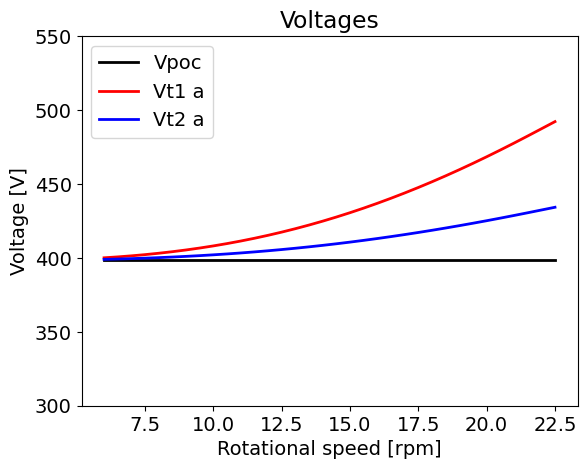

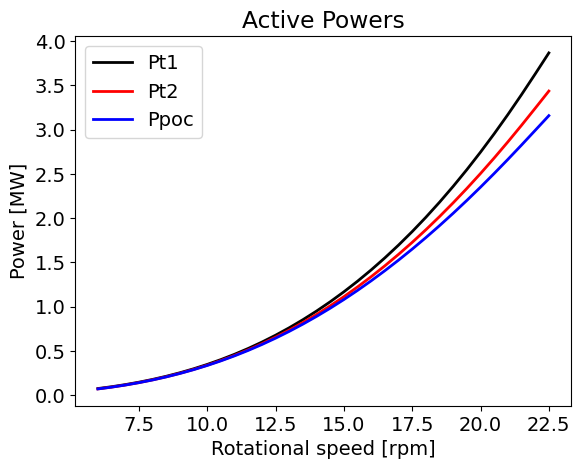

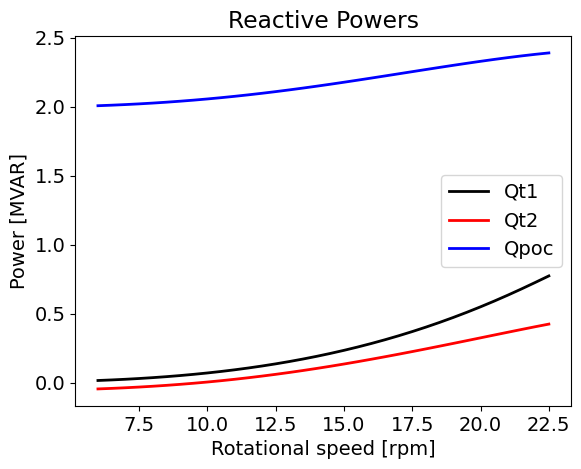

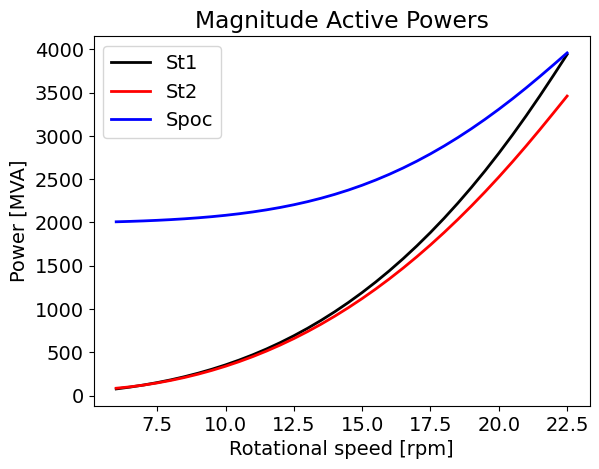

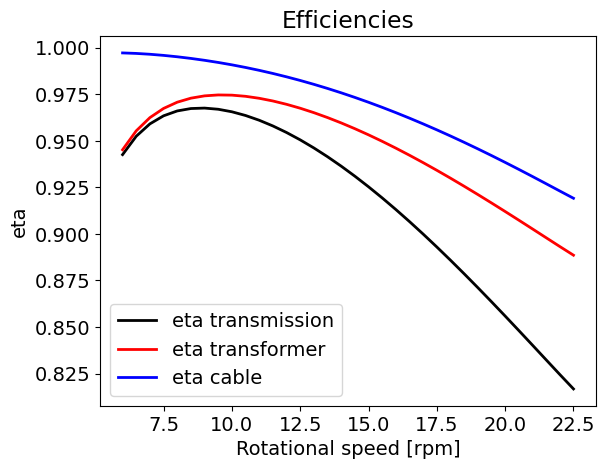

In [6]:

plt.rcParams.update({'font.size': 14})

plt.figure(1) 
plt.plot(Data2_a['N'], abs(Data2_a["Vg"]),   zorder=1, color='k', linewidth=2, linestyle='solid', label="Vpoc")
plt.plot(Data2_a['N'], abs(Data2_a["Vt1"]),  zorder=1, color='r', linewidth=2, linestyle='solid', label="Vt1 a")
plt.plot(Data2_a['N'], abs(Data2_a["Vt2"]),  zorder=1, color='b', linewidth=2, linestyle='solid', label="Vt2 a")

plt.legend()
plt.title('Voltages')
plt.xlabel('Rotational speed [rpm]')
plt.ylabel('Voltage [V]')

plt.ylim(300, 550)
#plt.yscale('log')


plt.figure(2) 
plt.plot(Data2_a['N'], np.real(Data2_a["St1"])/10**6,  zorder=1, color='k', linewidth=2, linestyle='solid', label="Pt1")
plt.plot(Data2_a['N'], np.real(Data2_a["St2"])/10**6,  zorder=1, color='r', linewidth=2, linestyle='solid', label="Pt2")
plt.plot(Data2_a['N'], np.real(Data2_a["Sg"] )/10**6,  zorder=1, color='b', linewidth=2, linestyle='solid', label="Ppoc")
plt.legend()
plt.title('Active Powers')
plt.xlabel('Rotational speed [rpm]')
plt.ylabel('Power [MW]')

plt.figure(3) 
plt.plot(Data2_a['N'], np.imag(Data2_a["St1"])/10**6,  zorder=1, color='k', linewidth=2, linestyle='solid', label="Qt1")
plt.plot(Data2_a['N'], np.imag(Data2_a["St2"])/10**6,  zorder=1, color='r', linewidth=2, linestyle='solid', label="Qt2")
plt.plot(Data2_a['N'], np.imag(Data2_a["Sg"] )/10**6,  zorder=1, color='b', linewidth=2, linestyle='solid', label="Qpoc")
plt.legend()
plt.title('Reactive Powers')
plt.xlabel('Rotational speed [rpm]')
plt.ylabel('Power [MVAR]')

plt.figure(4)
plt.plot(Data2_a['N'], np.abs(Data2_a["St1"])/10**3,  zorder=1, color='k', linewidth=2, linestyle='solid', label="St1")
plt.plot(Data2_a['N'], np.abs(Data2_a["St2"])/10**3,  zorder=1, color='r', linewidth=2, linestyle='solid', label="St2")
plt.plot(Data2_a['N'], np.abs(Data2_a["Sg"] )/10**3,  zorder=1, color='b', linewidth=2, linestyle='solid', label="Spoc")
plt.legend()
plt.title('Magnitude Active Powers')
plt.xlabel('Rotational speed [rpm]')
plt.ylabel('Power [MVA]')

plt.figure(5)
plt.plot(Data2_a['N'],(Data2_a['eta_transfo+cables']),  zorder=1, color='k', linewidth=2, linestyle='solid', label="eta transmission")
plt.plot(Data2_a['N'],(Data2_a['eta_transfo']),           zorder=1, color='r', linewidth=2, linestyle='solid', label="eta transformer")
plt.plot(Data2_a['N'],(Data2_a['eta_cables'] ),         zorder=1, color='b', linewidth=2, linestyle='solid', label="eta cable")
plt.legend()
plt.title('Efficiencies')
plt.xlabel('Rotational speed [rpm]')
plt.ylabel('eta')



plt.show()


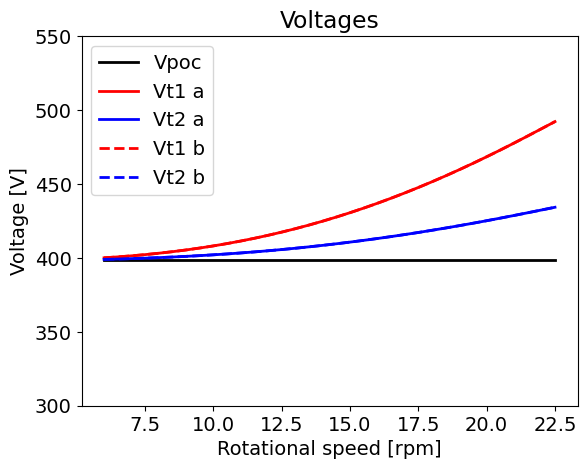

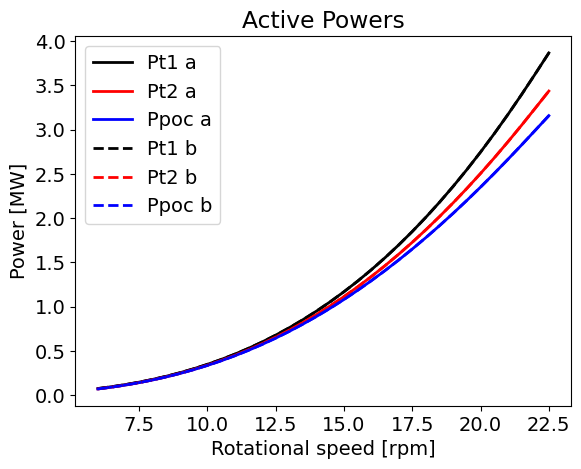

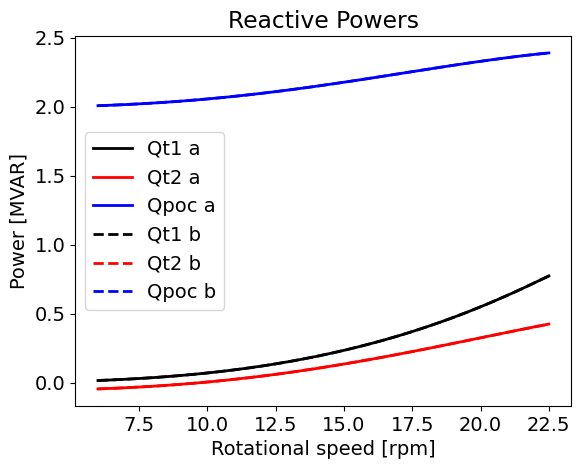

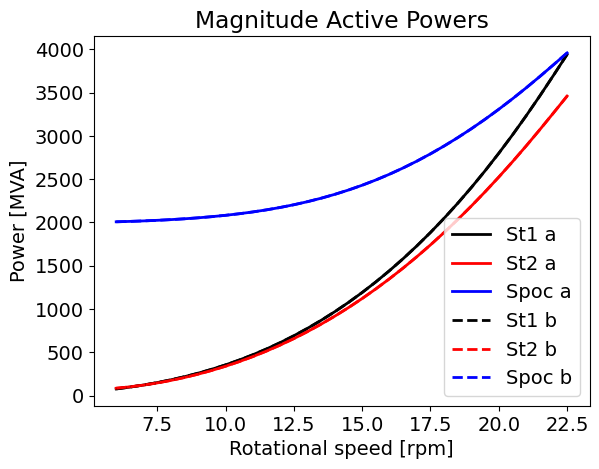

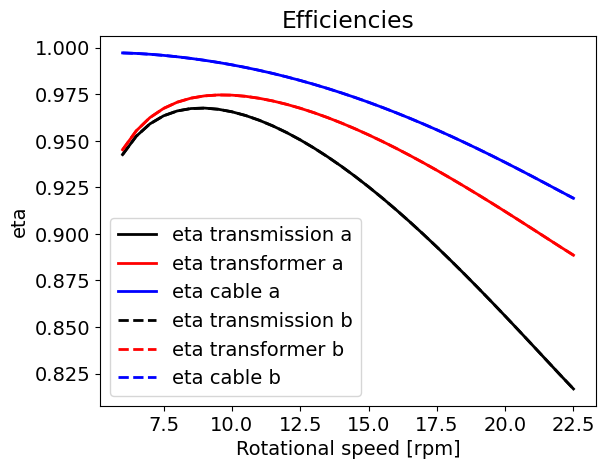

In [8]:

plt.rcParams.update({'font.size': 14})

plt.figure(1) 
plt.plot(Data2_a['N'], abs(Data2_a["Vg"]),   zorder=1, color='k', linewidth=2, linestyle='solid', label="Vpoc")
plt.plot(Data2_a['N'], abs(Data2_a["Vt1"]),  zorder=1, color='r', linewidth=2, linestyle='solid', label="Vt1 a")
plt.plot(Data2_a['N'], abs(Data2_a["Vt2"]),  zorder=1, color='b', linewidth=2, linestyle='solid', label="Vt2 a")
plt.plot(Data2_b['N'], abs(Data2_b["Vt1"]),  zorder=1, color='r', linewidth=2, linestyle='dashed', label="Vt1 b")
plt.plot(Data2_b['N'], abs(Data2_b["Vt2"]),  zorder=1, color='b', linewidth=2, linestyle='dashed', label="Vt2 b")

plt.legend()
plt.title('Voltages')
plt.xlabel('Rotational speed [rpm]')
plt.ylabel('Voltage [V]')

plt.ylim(300, 550)
#plt.yscale('log')


plt.figure(2) 
plt.plot(Data2_a['N'], np.real(Data2_a["St1"])/10**6,  zorder=1, color='k', linewidth=2, linestyle='solid', label="Pt1 a")
plt.plot(Data2_a['N'], np.real(Data2_a["St2"])/10**6,  zorder=1, color='r', linewidth=2, linestyle='solid', label="Pt2 a")
plt.plot(Data2_a['N'], np.real(Data2_a["Sg"] )/10**6,  zorder=1, color='b', linewidth=2, linestyle='solid', label="Ppoc a")
plt.plot(Data2_b['N'], np.real(Data2_b["St1"])/10**6,  zorder=1, color='k', linewidth=2, linestyle='dashed', label="Pt1 b")
plt.plot(Data2_b['N'], np.real(Data2_b["St2"])/10**6,  zorder=1, color='r', linewidth=2, linestyle='dashed', label="Pt2 b")
plt.plot(Data2_b['N'], np.real(Data2_b["Sg"] )/10**6,  zorder=1, color='b', linewidth=2, linestyle='dashed', label="Ppoc b")
plt.legend()
plt.title('Active Powers')
plt.xlabel('Rotational speed [rpm]')
plt.ylabel('Power [MW]')

plt.figure(3) 
plt.plot(Data2_a['N'], np.imag(Data2_a["St1"])/10**6,  zorder=1, color='k', linewidth=2, linestyle='solid', label="Qt1 a")
plt.plot(Data2_a['N'], np.imag(Data2_a["St2"])/10**6,  zorder=1, color='r', linewidth=2, linestyle='solid', label="Qt2 a")
plt.plot(Data2_a['N'], np.imag(Data2_a["Sg"] )/10**6,  zorder=1, color='b', linewidth=2, linestyle='solid', label="Qpoc a")
plt.plot(Data2_b['N'], np.imag(Data2_b["St1"])/10**6,  zorder=1, color='k', linewidth=2, linestyle='dashed', label="Qt1 b")
plt.plot(Data2_b['N'], np.imag(Data2_b["St2"])/10**6,  zorder=1, color='r', linewidth=2, linestyle='dashed', label="Qt2 b")
plt.plot(Data2_b['N'], np.imag(Data2_b["Sg"] )/10**6,  zorder=1, color='b', linewidth=2, linestyle='dashed', label="Qpoc b")
plt.legend()
plt.title('Reactive Powers')
plt.xlabel('Rotational speed [rpm]')
plt.ylabel('Power [MVAR]')

plt.figure(4)
plt.plot(Data2_a['N'], np.abs(Data2_a["St1"])/10**3,  zorder=1, color='k', linewidth=2, linestyle='solid', label="St1 a")
plt.plot(Data2_a['N'], np.abs(Data2_a["St2"])/10**3,  zorder=1, color='r', linewidth=2, linestyle='solid', label="St2 a")
plt.plot(Data2_a['N'], np.abs(Data2_a["Sg"] )/10**3,  zorder=1, color='b', linewidth=2, linestyle='solid', label="Spoc a")
plt.plot(Data2_b['N'], np.abs(Data2_b["St1"])/10**3,  zorder=1, color='k', linewidth=2, linestyle='dashed', label="St1 b")
plt.plot(Data2_b['N'], np.abs(Data2_b["St2"])/10**3,  zorder=1, color='r', linewidth=2, linestyle='dashed', label="St2 b")
plt.plot(Data2_b['N'], np.abs(Data2_b["Sg"] )/10**3,  zorder=1, color='b', linewidth=2, linestyle='dashed', label="Spoc b")
plt.legend()
plt.title('Magnitude Active Powers')
plt.xlabel('Rotational speed [rpm]')
plt.ylabel('Power [MVA]')

plt.figure(5)
plt.plot(Data2_a['N'],(Data2_a['eta_transfo+cables']),  zorder=1, color='k', linewidth=2, linestyle='solid', label="eta transmission a")
plt.plot(Data2_a['N'],(Data2_a['eta_transfo']),         zorder=1, color='r', linewidth=2, linestyle='solid', label="eta transformer a")
plt.plot(Data2_a['N'],(Data2_a['eta_cables'] ),         zorder=1, color='b', linewidth=2, linestyle='solid', label="eta cable a")
plt.plot(Data2_b['N'],(Data2_b['eta_transfo+cables']),  zorder=1, color='k', linewidth=2, linestyle='dashed', label="eta transmission b")
plt.plot(Data2_b['N'],(Data2_b['eta_transfo']),         zorder=1, color='r', linewidth=2, linestyle='dashed', label="eta transformer b")
plt.plot(Data2_b['N'],(Data2_b['eta_cables'] ),         zorder=1, color='b', linewidth=2, linestyle='dashed', label="eta cable b")
plt.legend()
plt.title('Efficiencies')
plt.xlabel('Rotational speed [rpm]')
plt.ylabel('eta')



plt.show()
